In [10]:
# Task A – Determine flight path bounding box
import time
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
import geopandas as gpd
import os

# --- Paths ---
pos_path = "20200910_BlakesOpening_site3_flight1z.pos"
gpkg_path = "uas_flight.gpkg"
layer_name = "flight_path"

t0 = time.perf_counter()

# --- Read .pos file ---
col_names = [
    "timestamp", "lat", "lon", "height_m",
    "Q", "Q_text", "sats",
    "SDNorth_m", "SDEast_m", "SDHeight_m", "StdDev_m"
]

df = pd.read_csv(
    pos_path,
    comment="%",        # skip RTKLIB header rows
    header=None,
    names=col_names,
    dtype={
        "lat": float, "lon": float, "height_m": float,
        "Q": "Int64", "sats": "Int64",
        "SDNorth_m": float, "SDEast_m": float, "SDHeight_m": float, "StdDev_m": float
    }
)

read_time = time.perf_counter() - t0

# Drop rows without coordinates
df = df.dropna(subset=["lat", "lon"]).reset_index(drop=True)

# --- Create GeoDataFrame in WGS84 (EPSG:7844) and project to MGA2020 / Zone 55 (EPSG:7855) ---
gdf_wgs84 = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["lon"], df["lat"])],
    crs="EPSG:7844"
)
gdf = gdf_wgs84.to_crs("EPSG:7855")

# --- Bounding box + height range ---
minx, miny, maxx, maxy = gdf.total_bounds
min_h = float(np.nanmin(gdf["height_m"]))
max_h = float(np.nanmax(gdf["height_m"]))

# --- LineString and length ---
line = LineString(list(gdf.geometry.values))
line_gdf = gpd.GeoDataFrame(
    {"total_length_m": [line.length]},
    geometry=[line],
    crs=gdf.crs
)

# Save to GeoPackage
if os.path.exists(gpkg_path):
    os.remove(gpkg_path)
line_gdf.to_file(gpkg_path, layer=layer_name, driver="GPKG")

calc_time = time.perf_counter() - t0 - read_time

# --- Nicely formatted printouts ---
def fmt_m(x): return f"{x:,.3f} m"

print("A) Determine flight path bounding box — outputs")
print("------------------------------------------------")
print("Bounding Box (EPSG:7855):")
print(f"  Easting min:  {fmt_m(minx)}")
print(f"  Easting max:  {fmt_m(maxx)}")
print(f"  Northing min: {fmt_m(miny)}")
print(f"  Northing max: {fmt_m(maxy)}")
print("Heights:")
print(f"  Height min:   {fmt_m(min_h)}")
print(f"  Height max:   {fmt_m(max_h)}")
print("Timings:")
print(f"  Read .pos:          {read_time:.3f} s")
print(f"  Calculations total: {calc_time:.3f} s")
print(f"Total flight path length: {fmt_m(line.length)}")
print(f"GeoPackage written: {gpkg_path} (layer: {layer_name})")


A) Determine flight path bounding box — outputs
------------------------------------------------
Bounding Box (EPSG:7855):
  Easting min:  467,724.652 m
  Easting max:  468,410.536 m
  Northing min: 5,225,706.246 m
  Northing max: 5,226,080.720 m
Heights:
  Height min:   281.855 m
  Height max:   304.533 m
Timings:
  Read .pos:          0.049 s
  Calculations total: 0.601 s
Total flight path length: 3,663.539 m
GeoPackage written: uas_flight.gpkg (layer: flight_path)


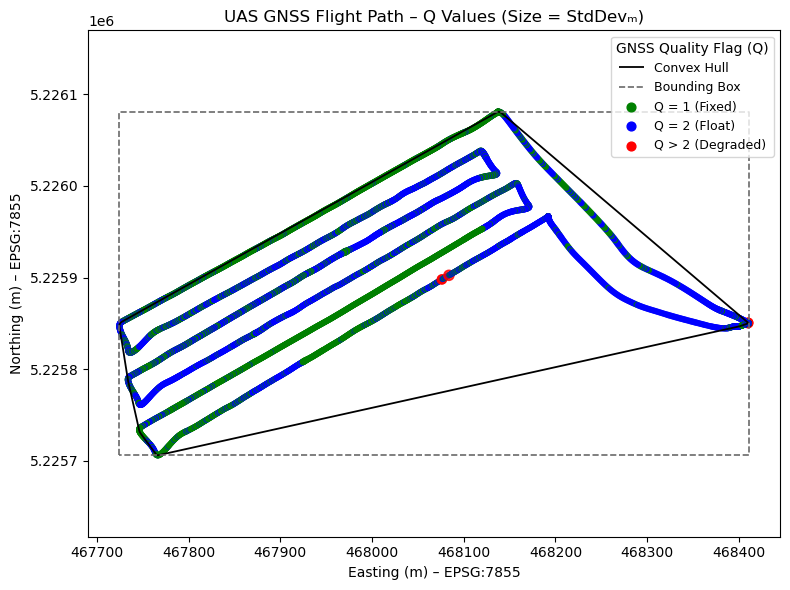

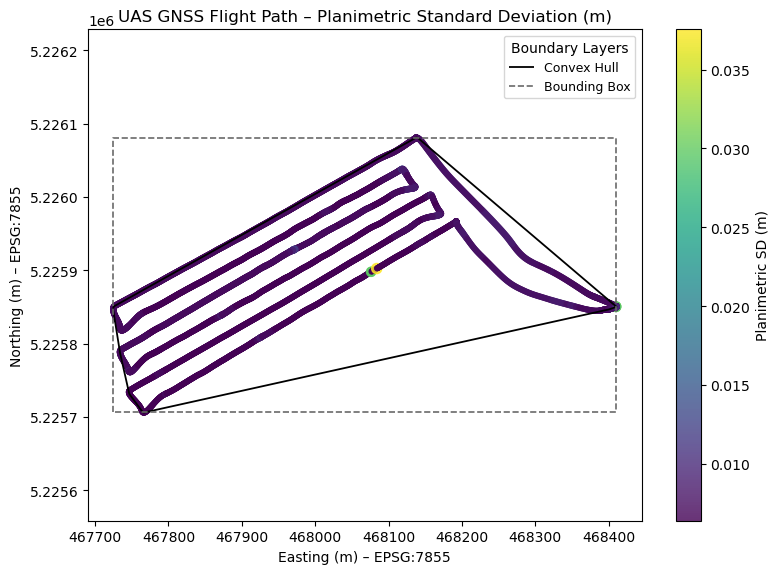

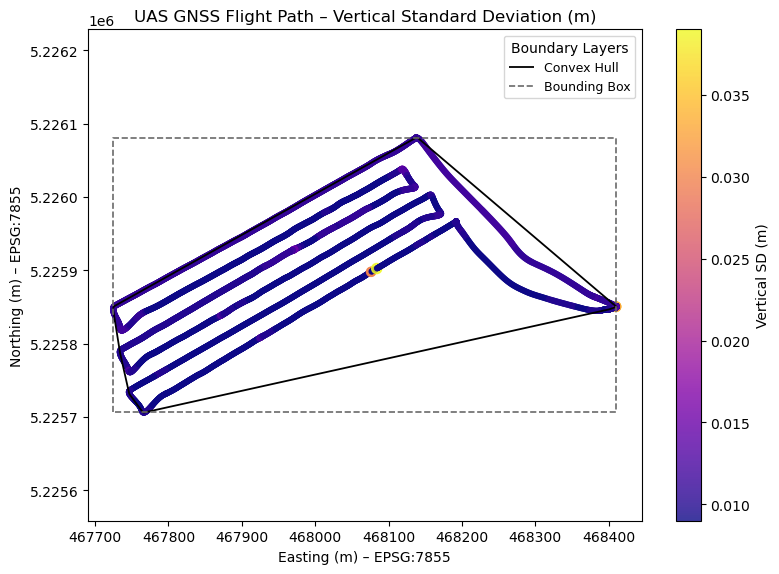

In [11]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box

# ----------------------------------------------------
# Compute Planimetric Standard Deviation
# ----------------------------------------------------
gdf["SDPlanimetric_m"] = np.sqrt(gdf["SDEast_m"]**2 + gdf["SDNorth_m"]**2)

# ----------------------------------------------------
# Convex hull and bounding box
# ----------------------------------------------------
convex_hull = gdf.union_all().convex_hull
convex_gdf = gpd.GeoDataFrame(geometry=[convex_hull], crs=gdf.crs)

minx, miny, maxx, maxy = gdf.total_bounds
bbox = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs=gdf.crs)

# ----------------------------------------------------
# Define Q-colour logic
# ----------------------------------------------------
conditions = [
    gdf["Q"] == 1,
    gdf["Q"] == 2,
    gdf["Q"] > 2
]
choices = ["green", "blue", "red"]
colors = np.select(conditions, choices, default="lightgrey")

# ====================================================
# PLOT 1: Categorical Q Values
# ====================================================
plt.figure(figsize=(8,6))
plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=colors,
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)

convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.3, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="dimgray", linewidth=1.2, linestyle="--", label="Bounding Box")

plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Q Values (Size = StdDevₘ)")
plt.axis("equal")

# --- Legend ---
plt.scatter([], [], color="green", s=40, label="Q = 1 (Fixed)")
plt.scatter([], [], color="blue", s=40, label="Q = 2 (Float)")
plt.scatter([], [], color="red", s=40, label="Q > 2 (Degraded)")
plt.legend(
    title="GNSS Quality Flag (Q)",
    loc="upper right",
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

plt.tight_layout()
plt.show()

# ====================================================
# PLOT 2: Planimetric Standard Deviation
# ====================================================
plt.figure(figsize=(8,6))
sc2 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDPlanimetric_m"],
    cmap="viridis",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)

convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.3, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="dimgray", linewidth=1.2, linestyle="--", label="Bounding Box")

plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Planimetric Standard Deviation (m)")
plt.axis("equal")

# --- Colourbar & legend ---
cb = plt.colorbar(sc2)
cb.set_label("Planimetric SD (m)", fontsize=10)
plt.legend(
    loc="upper right",
    frameon=True,
    fontsize=9,
    title="Boundary Layers",
    title_fontsize=10
)

plt.tight_layout()
plt.show()

# ====================================================
# PLOT 3: Vertical Standard Deviation
# ====================================================
plt.figure(figsize=(8,6))
sc3 = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["SDHeight_m"],
    cmap="plasma",
    s=gdf["StdDev_m"] * 1000,
    alpha=0.8
)

convex_gdf.boundary.plot(ax=plt.gca(), color="black", linewidth=1.3, label="Convex Hull")
bbox_gdf.boundary.plot(ax=plt.gca(), color="dimgray", linewidth=1.2, linestyle="--", label="Bounding Box")

plt.xlabel("Easting (m) – EPSG:7855")
plt.ylabel("Northing (m) – EPSG:7855")
plt.title("UAS GNSS Flight Path – Vertical Standard Deviation (m)")
plt.axis("equal")

# --- Colourbar & legend ---
cb2 = plt.colorbar(sc3)
cb2.set_label("Vertical SD (m)", fontsize=10)
plt.legend(
    loc="upper right",
    frameon=True,
    fontsize=9,
    title="Boundary Layers",
    title_fontsize=10
)

plt.tight_layout()
plt.show()


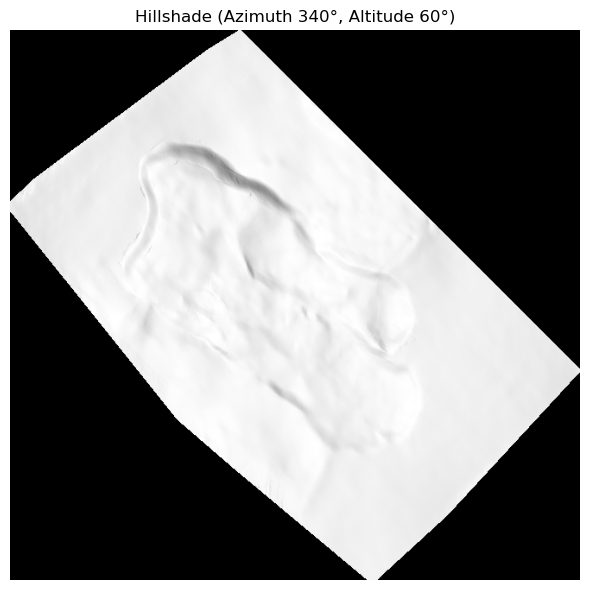

Hillshade raster written: Homehill_2020_Hillshade.tif


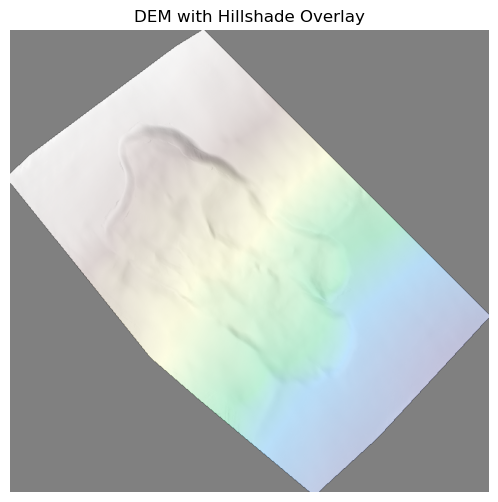

the time to run script was 0.7071607999969274 seconds
the time to run the hillshade was 0.235513300052844 seconds


In [12]:
import rasterio

time_0 = time.perf_counter()

dem_path = "Homehill_2020_DSM_30cm.tif"

with rasterio.open(dem_path) as src:
    dem = src.read(1, masked = True)
    transform = src.transform
    crs = src.crs
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]

azimuth_deg = 340
altitude_deg = 60

azimuth_rad = np.radians(360.0 - azimuth_deg + 90.0)
altitude_rad = np.radians(altitude_deg)

dy, dx = np.gradient(dem.filled(np.nan), pixel_size_y, pixel_size_x)

slope_rad = np.arctan(np.sqrt(dy**2 + dx**2))
aspect_rad = np.arctan2(-dx, dy)
aspect_rad = np.where(aspect_rad < 0, 2 * np.pi + aspect_rad, aspect_rad)

time_1 = time.perf_counter()

# --- Hillshade formula ---
hillshade = (
    np.sin(altitude_rad) * np.cos(slope_rad)
    + np.cos(altitude_rad) * np.sin(slope_rad) * np.cos(azimuth_rad - aspect_rad)
)

# Scale to 0–255 for display
# Clip valid range and replace NaNs with 0 before casting
hillshade_scaled = np.clip(hillshade, 0, 1)
hillshade_scaled = np.where(np.isnan(hillshade_scaled), 0, hillshade_scaled)
hillshade_scaled = (hillshade_scaled * 255).astype(np.uint8)


# --- Plot results ---
plt.figure(figsize=(8,6))
plt.imshow(hillshade_scaled, cmap="gray")
plt.title("Hillshade (Azimuth 340°, Altitude 60°)")
plt.axis("off")
plt.tight_layout()
plt.show()

time_hillshade = time.perf_counter() - time_1
# --- write hillshade to GeoTIFF ---
out_path = "Homehill_2020_Hillshade.tif"
with rasterio.open(
    out_path,
    "w",
    driver="GTiff",
    height=hillshade_scaled.shape[0],
    width=hillshade_scaled.shape[1],
    count=1,
    dtype=np.uint8,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(hillshade_scaled, 1)

print(f"Hillshade raster written: {out_path}")

plt.figure(figsize=(8,6))
plt.imshow(dem, cmap="terrain", alpha=0.5)
plt.imshow(hillshade_scaled, cmap="gray", alpha=0.5)
plt.title("DEM with Hillshade Overlay")
plt.axis("off")
plt.show()

time_script = time.perf_counter() - time_0

print(f"the time to run script was {time_script} seconds")
print(f"the time to run the hillshade was {time_hillshade} seconds")

In [13]:
from pathlib import Path

# ----------------------------------------------------
# File paths
# ----------------------------------------------------
infile = "Homehill_2020_DSM_30cm.tif"

# ----------------------------------------------------
# Load DEM
# ----------------------------------------------------
with rasterio.open(infile) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        dem[dem == nodata] = np.nan  # replace nodata with NaN
    transform = src.transform
    crs = src.crs
    cellsize = transform[0]
    profile = src.profile

nrows, ncols = dem.shape
print("Loaded DEM:", np.nanmin(dem), "to", np.nanmax(dem))

# ----------------------------------------------------
# Prepare empty arrays
# ----------------------------------------------------
mean_slope = np.full((nrows, ncols), np.nan, dtype=np.float32)
min_slope  = np.full((nrows, ncols), np.nan, dtype=np.float32)
max_slope  = np.full((nrows, ncols), np.nan, dtype=np.float32)

# ----------------------------------------------------
# Define FM-simple slope function (NaN-safe)
# ----------------------------------------------------
def fm_simple_kernel(center, north, south, east, west, cellsize):
    """Return mean, min, max slope (°) for the 5-cell cross."""
    diffs = np.abs(np.array([center - north,
                             center - south,
                             center - east,
                             center - west],
                             dtype=float))
    diffs = diffs[np.isfinite(diffs)]  # remove NaNs if any
    if diffs.size == 0:
        return np.nan, np.nan, np.nan

    slopes_deg = np.degrees(np.arctan(diffs / cellsize))
    mean_s = np.nanmean(slopes_deg)
    min_s  = np.nanmin(slopes_deg)
    max_s  = np.nanmax(slopes_deg)
    return mean_s, min_s, max_s

# ----------------------------------------------------
# Move the 5-cell kernel across the DEM
# ----------------------------------------------------
for r in range(1, nrows - 1):
    for c in range(1, ncols - 1):
        # Skip if the centre or any neighbour is NaN
        window = dem[r-1:r+2, c-1:c+2]
        if np.isnan(window).any():
            continue

        center = dem[r, c]
        north  = dem[r - 1, c]
        south  = dem[r + 1, c]
        east   = dem[r, c + 1]
        west   = dem[r, c - 1]

        mean_val, min_val, max_val = fm_simple_kernel(center, north, south, east, west, cellsize)
        mean_slope[r, c] = mean_val
        min_slope[r, c]  = min_val
        max_slope[r, c]  = max_val

# ----------------------------------------------------
# Write outputs
# ----------------------------------------------------
profile.update(dtype="float32", count=1, nodata=np.nan)

with rasterio.open("Homehill_DEM_Slope_FM_mean.tif", "w", **profile) as dst:
    dst.write(mean_slope, 1)
with rasterio.open("Homehill_DEM_Slope_FM_min.tif", "w", **profile) as dst:
    dst.write(min_slope, 1)
with rasterio.open("Homehill_DEM_Slope_FM_max.tif", "w", **profile) as dst:
    dst.write(max_slope, 1)

# ----------------------------------------------------
# Diagnostics
# ----------------------------------------------------
print("✅ FM-simple slope rasters (mean, min, max) written successfully.")
print(f"Mean slope range: {np.nanmin(mean_slope):.2f} – {np.nanmax(mean_slope):.2f}°")
print(f"Min slope range:  {np.nanmin(min_slope):.2f} – {np.nanmax(min_slope):.2f}°")
print(f"Max slope range:  {np.nanmin(max_slope):.2f} – {np.nanmax(max_slope):.2f}°")


Loaded DEM: 49.71183776855469 to 100.39253234863281
✅ FM-simple slope rasters (mean, min, max) written successfully.
Mean slope range: 0.66 – 46.86°
Min slope range:  0.00 – 40.20°
Max slope range:  0.99 – 60.89°


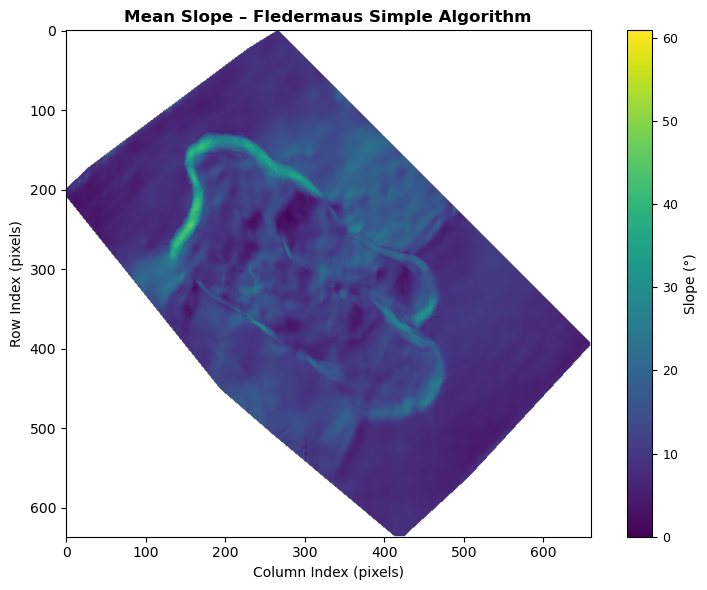

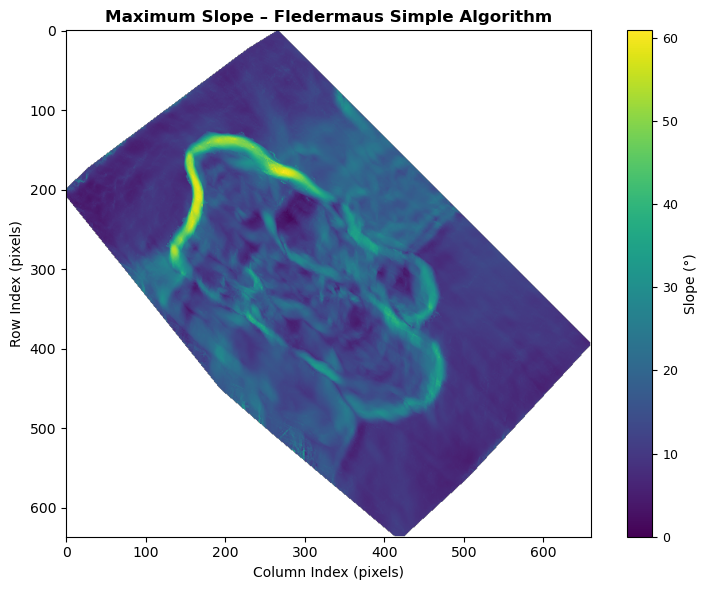

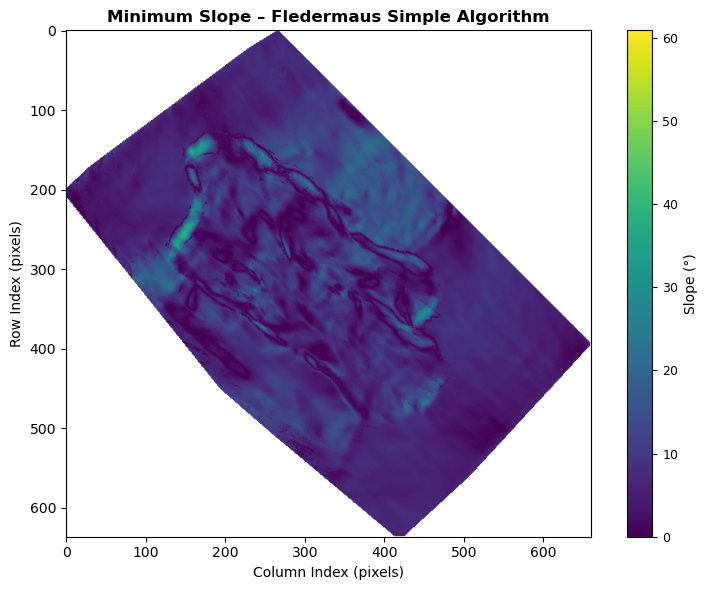

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute common colour limits for consistent scale
vmin = np.nanmin([mean_slope, min_slope, max_slope])
vmax = np.nanmax([mean_slope, min_slope, max_slope])

# Common colormap
cmap = "viridis"

# Optional: use georeferenced extent (if using rasterio)
# extent = [transform[2], transform[2] + mean_slope.shape[1] * transform[0],
#           transform[5] + mean_slope.shape[0] * transform[4], transform[5]]

# ----------------------------------------------------
# Plot 1: Mean Slope
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(mean_slope, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Mean Slope – Fledermaus Simple Algorithm", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 2: Maximum Slope
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(max_slope, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Maximum Slope – Fledermaus Simple Algorithm", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Plot 3: Minimum Slope
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(min_slope, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Minimum Slope – Fledermaus Simple Algorithm", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.show()



In [17]:
# ----------------------------------------------------
# File paths
# ----------------------------------------------------
infile = "Homehill_2020_DSM_30cm.tif"

# ----------------------------------------------------
# Load DEM
# ----------------------------------------------------
with rasterio.open(infile) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    if nodata is not None:
        dem[dem == nodata] = np.nan
    transform = src.transform
    crs = src.crs
    cellsize = transform[0]
    profile = src.profile

nrows, ncols = dem.shape
print("Loaded DEM:", np.nanmin(dem), "to", np.nanmax(dem))

# ----------------------------------------------------
# Prepare empty output arrays
# ----------------------------------------------------
mean_slope_1 = np.full((nrows, ncols), np.nan, dtype=np.float32)
min_slope_1  = np.full((nrows, ncols), np.nan, dtype=np.float32)
max_slope_1  = np.full((nrows, ncols), np.nan, dtype=np.float32)

# ----------------------------------------------------
# Define FM-simple kernel for 9x9 cross (radius = 4)
# ----------------------------------------------------
def fm_simple_kernel_9x9(center, north, south, east, west, horiz_dist):
    """Return mean, min, max slope (°) using outermost N/S/E/W cells."""
    diffs = np.abs(np.array([center - north,
                             center - south,
                             center - east,
                             center - west], dtype=float))
    diffs = diffs[np.isfinite(diffs)]   # drop NaNs
    if diffs.size == 0:
        return np.nan, np.nan, np.nan

    slopes_deg = np.degrees(np.arctan(diffs / horiz_dist))
    return np.nanmean(slopes_deg), np.nanmin(slopes_deg), np.nanmax(slopes_deg)

# ----------------------------------------------------
# Move 9x9 cross-shaped kernel over DEM
# ----------------------------------------------------
radius = 4  # 9x9 = radius of 4 cells
for r in range(radius, nrows - radius):
    for c in range(radius, ncols - radius):
        # Gather centre + outermost N,S,E,W
        window_vals = [dem[r, c],
                       dem[r - radius, c],  # north
                       dem[r + radius, c],  # south
                       dem[r, c + radius],  # east
                       dem[r, c - radius]]  # west

        # Skip if any are NaN
        if np.any(np.isnan(window_vals)):
            continue

        center = window_vals[0]
        north, south, east, west = window_vals[1:]
        mean_val, min_val, max_val = fm_simple_kernel_9x9(center, north, south, east, west, radius * cellsize)
        mean_slope_1[r, c] = mean_val
        min_slope_1[r, c]  = min_val
        max_slope_1[r, c]  = max_val

# ----------------------------------------------------
# Write outputs
# ----------------------------------------------------
profile.update(dtype="float32", count=1, nodata=np.nan)

with rasterio.open("Homehill_DEM_Slope_FM9x9_mean.tif", "w", **profile) as dst:
    dst.write(mean_slope_1, 1)
with rasterio.open("Homehill_DEM_Slope_FM9x9_min.tif", "w", **profile) as dst:
    dst.write(min_slope_1, 1)
with rasterio.open("Homehill_DEM_Slope_FM9x9_max.tif", "w", **profile) as dst:
    dst.write(max_slope_1, 1)

# ----------------------------------------------------
# Diagnostics
# ----------------------------------------------------
print("✅ FM-simple 9×9 (outermost N,S,E,W) slope rasters written successfully.")
print(f"Mean slope range: {np.nanmin(mean_slope_1):.2f} – {np.nanmax(mean_slope_1):.2f}°")
print(f"Min slope range:  {np.nanmin(min_slope_1):.2f} – {np.nanmax(min_slope_1):.2f}°")
print(f"Max slope range:  {np.nanmin(max_slope_1):.2f} – {np.nanmax(max_slope_1):.2f}°")

Loaded DEM: 49.71183776855469 to 100.39253234863281
✅ FM-simple 9×9 (outermost N,S,E,W) slope rasters written successfully.
Mean slope range: 0.88 – 44.41°
Min slope range:  0.00 – 38.81°
Max slope range:  1.30 – 59.49°


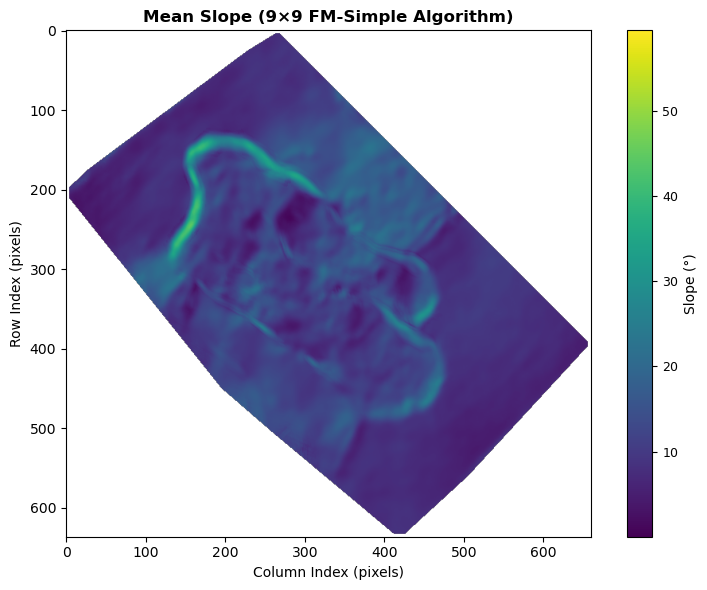

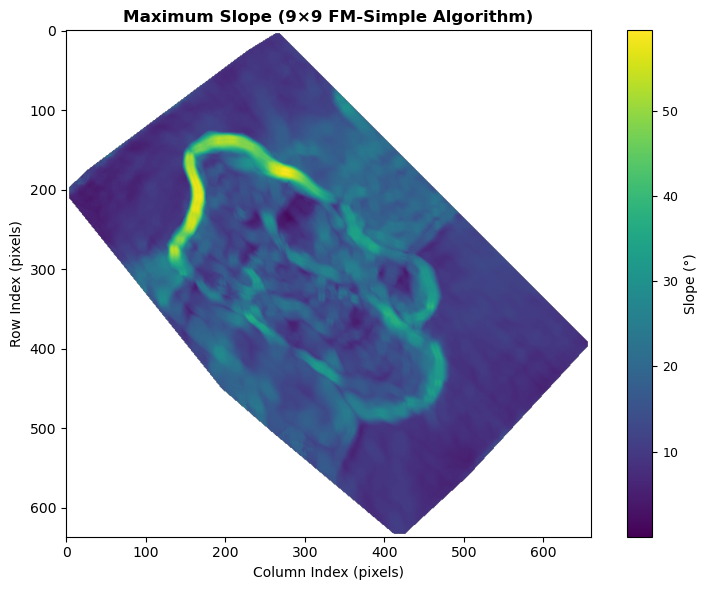

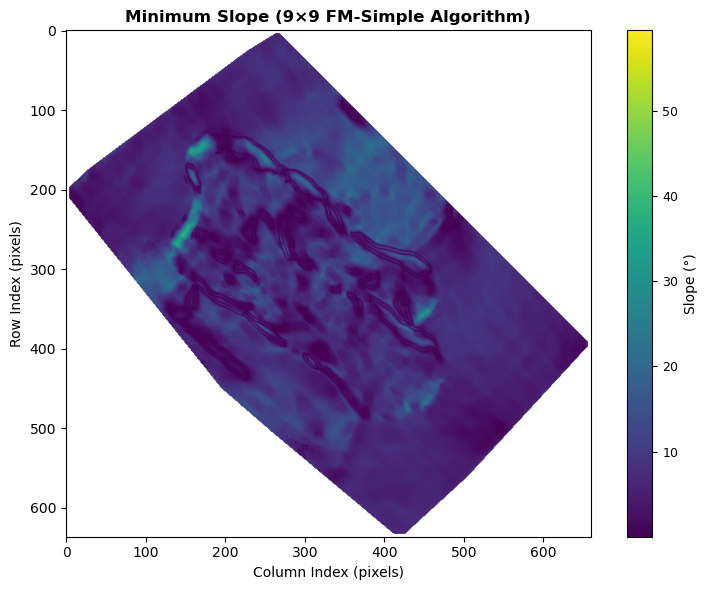

✅ All 9×9 FM-simple slope plots saved as PNGs in the 'plot_outputs' folder.


In [20]:
import matplotlib.pyplot as plt
import os
import numpy as np

# ----------------------------------------------------
# Create output folder for plots
# ----------------------------------------------------
os.makedirs("plot_outputs", exist_ok=True)

# ----------------------------------------------------
# Define consistent colour scale and colormap
# ----------------------------------------------------
vmin = np.nanmin([mean_slope_1, min_slope_1, max_slope_1])
vmax = np.nanmax([mean_slope_1, min_slope_1, max_slope_1])
cmap = "viridis"

# ----------------------------------------------------
# Plot 1 – Mean Slope (9×9)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(mean_slope_1, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Mean Slope (9×9 FM-Simple Algorithm)", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.savefig("plot_outputs/mean_slope_9x9.png", dpi=300, bbox_inches="tight")
plt.show()

# ----------------------------------------------------
# Plot 2 – Maximum Slope (9×9)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(max_slope_1, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Maximum Slope (9×9 FM-Simple Algorithm)", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.savefig("plot_outputs/max_slope_9x9.png", dpi=300, bbox_inches="tight")
plt.show()

# ----------------------------------------------------
# Plot 3 – Minimum Slope (9×9)
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.imshow(min_slope_1, cmap=cmap, vmin=vmin, vmax=vmax)
cb = plt.colorbar(label="Slope (°)")
cb.ax.tick_params(labelsize=9)
plt.title("Minimum Slope (9×9 FM-Simple Algorithm)", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.grid(False)
plt.tight_layout()
plt.savefig("plot_outputs/min_slope_9x9.png", dpi=300, bbox_inches="tight")
plt.show()

# ----------------------------------------------------
# Confirmation
# ----------------------------------------------------
print("✅ All 9×9 FM-simple slope plots saved as PNGs in the 'plot_outputs' folder.")


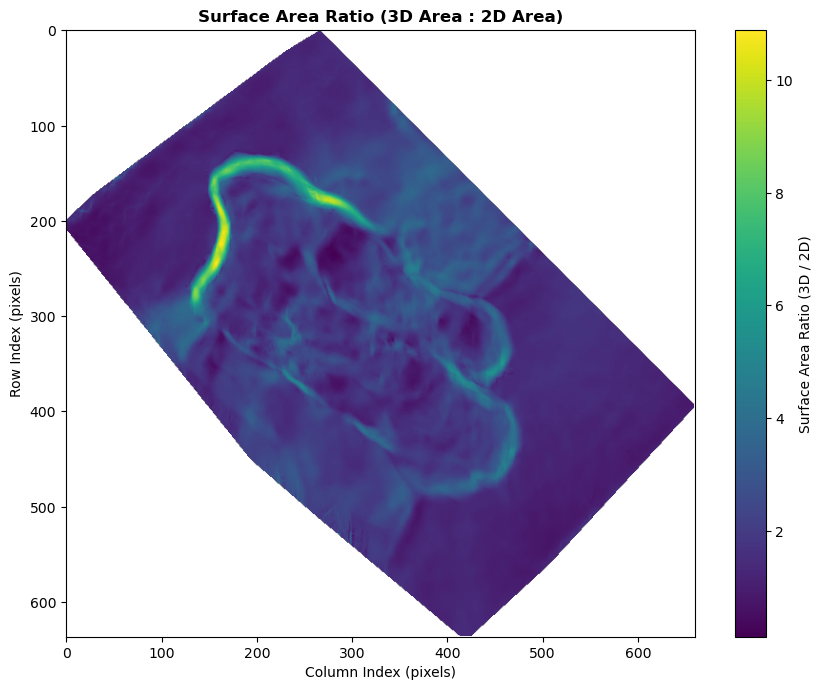

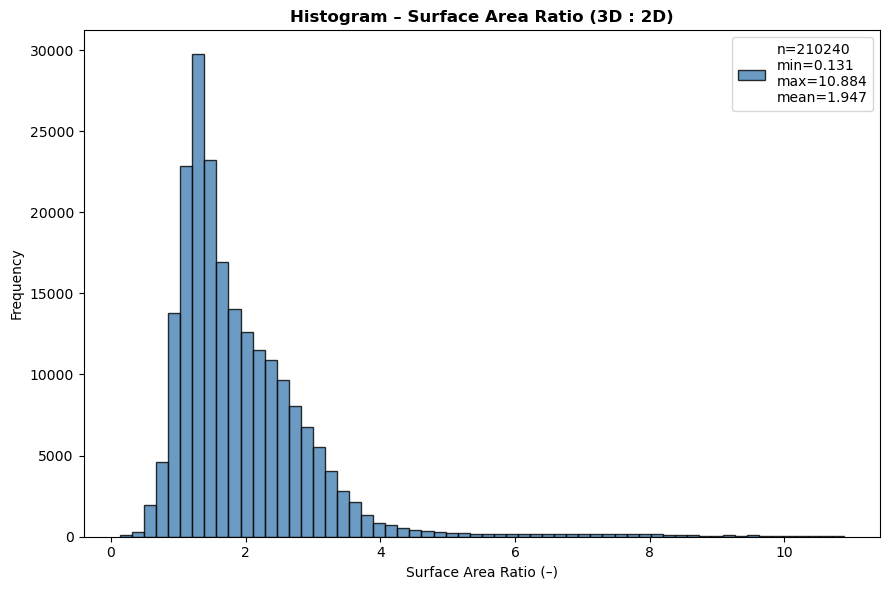

=== Surface Area Ratio – Descriptive Statistics ===
Min    : 0.130610
Max    : 10.883873
Mean   : 1.946596
Std    : 1.093407
Kurtosis (excess): 13.788462
GeoTIFF written: Homehill_DEM_SurfaceAreaRatio.tif
Elapsed time – Surface→Ratio computation only: 0.000 s
Elapsed time – Script up to end of Task E: 1.946 s
✅ Plots exported as JPEGs to 'plot_outputs':
 • ratio_map.jpg (Plot 1 – Surface Area Ratio)
 • ratio_histogram.jpg (Plot 2 – Histogram)


In [27]:
# ====================================================
# Tasks c–i: Visualisation, Histogram, Stats, GeoTIFF, Timings
# ====================================================

import os, time
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis

# --- Start timers
t_all_start = time.perf_counter()
t_ratio_start = time.perf_counter()

# (you may already have ratio computation above)

t_ratio_seconds = time.perf_counter() - t_ratio_start

# --- Ensure output folder
os.makedirs("plot_outputs", exist_ok=True)

# ====================================================
# (c)  Plot 1 – Surface Area Ratio map
# ====================================================
ratio_valid = ratio[np.isfinite(ratio)]
vmin, vmax = np.nanmin(ratio_valid), np.nanmax(ratio_valid)

plt.figure(figsize=(9, 7))
im = plt.imshow(ratio, cmap="viridis", vmin=vmin, vmax=vmax)
cb = plt.colorbar(im)
cb.set_label("Surface Area Ratio (3D / 2D)", fontsize=10)
plt.title("Surface Area Ratio (3D Area : 2D Area)", fontsize=12, fontweight="bold")
plt.xlabel("Column Index (pixels)")
plt.ylabel("Row Index (pixels)")
plt.tight_layout()
plt.savefig("plot_outputs/ratio_map.jpg", dpi=300, bbox_inches="tight")
plt.show()

# ====================================================
# (d)  Plot 2 – Histogram of ratio values
# ====================================================
plt.figure(figsize=(9, 6))
plt.hist(ratio_valid, bins=60, color="steelblue", edgecolor="black", alpha=0.8)
plt.title("Histogram – Surface Area Ratio (3D : 2D)", fontsize=12, fontweight="bold")
plt.xlabel("Surface Area Ratio (–)")
plt.ylabel("Frequency")
plt.legend([f"n={len(ratio_valid)}\n"
            f"min={np.nanmin(ratio_valid):.3f}\n"
            f"max={np.nanmax(ratio_valid):.3f}\n"
            f"mean={np.nanmean(ratio_valid):.3f}"], loc="upper right")
plt.tight_layout()
plt.savefig("plot_outputs/ratio_histogram.jpg", dpi=300, bbox_inches="tight")
plt.show()

# ====================================================
# (e)  Descriptive statistics
# ====================================================
sar_min  = np.nanmin(ratio_valid)
sar_max  = np.nanmax(ratio_valid)
sar_mean = np.nanmean(ratio_valid)
sar_std  = np.nanstd(ratio_valid, ddof=1)
sar_kurt = kurtosis(ratio_valid, fisher=True, bias=False)

print("=== Surface Area Ratio – Descriptive Statistics ===")
print(f"Min    : {sar_min:.6f}")
print(f"Max    : {sar_max:.6f}")
print(f"Mean   : {sar_mean:.6f}")
print(f"Std    : {sar_std:.6f}")
print(f"Kurtosis (excess): {sar_kurt:.6f}")

# ====================================================
# (f)  Write ratio to GeoTIFF
# ====================================================
ratio_profile = profile.copy()
ratio_profile.update(dtype="float32", count=1, nodata=np.nan)

out_tif = "Homehill_DEM_SurfaceAreaRatio.tif"
with rasterio.open(out_tif, "w", **ratio_profile) as dst:
    dst.write(ratio.astype("float32"), 1)
print(f"GeoTIFF written: {out_tif}")

# ====================================================
# (g)  Timings
# ====================================================
t_all_end = time.perf_counter()
t_all_seconds = t_all_end - t_all_start

print(f"Elapsed time – Surface→Ratio computation only: {t_ratio_seconds:.3f} s")
print(f"Elapsed time – Script up to end of Task E: {t_all_seconds:.3f} s")

# ====================================================
# (i)  Confirmation
# ====================================================
print("✅ Plots exported as JPEGs to 'plot_outputs':")
print(" • ratio_map.jpg (Plot 1 – Surface Area Ratio)")
print(" • ratio_histogram.jpg (Plot 2 – Histogram)")
